# C964 Capstone 
## Game Reccomendation System
## By Diomy Gabasan Jr 


 Load and Process Data

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display, clear_output

# reading in data and creating data frames to preprocess the data
df = pd.read_csv("steam.csv")
df = df[df['price'] > 0]
df = df.dropna()

#naming features to be used in clustering
features = ["genres", "positive_ratings", "average_playtime", "price"]
num_features = ["positive_ratings", "average_playtime", "price"]

#preprocessing of data
g_df = df[features].dropna()
g_df['genres'] = g_df['genres'].str.split(';')
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(g_df['genres']),
    columns=mlb.classes_,
    index=g_df.index)

#scaling the numerical data and combining the numerical + genres
scaler = RobustScaler()
num_scaled = pd.DataFrame(
    scaler.fit_transform(g_df[num_features]),
    columns=num_features,
    index=g_df.index)
data_encoded = pd.concat([num_scaled, genre_encoded], axis=1)

Application of k-Means Clustering

In [2]:
#k-Means clustering algorithm
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_encoded)

#applying custers to the main dataframe
df['cluster'] = clusters
num_cluster = df.groupby('cluster')[num_features].mean()
genre_cluster_df = pd.concat([genre_encoded, df["cluster"]], axis=1)
genre_encoded_with_cluster = genre_encoded.copy()
genre_encoded_with_cluster['cluster'] = df['cluster']
cluster_genres = genre_encoded_with_cluster.groupby('cluster').mean()

Data Validation

In [3]:
#average overall silhouette score 
score = silhouette_score(data_encoded, kmeans.labels_)
print(f"Silhouette Score for {kmeans.n_clusters} clusters: {score:.3f}")

Silhouette Score for 8 clusters: 0.881


In [4]:
#average silhouette score per cluster
silhouette_val = silhouette_samples(data_encoded, clusters)
df["silhouette"] = silhouette_val
cluster_silhouette = df.groupby("cluster")["silhouette"].mean().sort_values(ascending=False)
print("avg silhouette score per cluster:")
print(cluster_silhouette)

avg silhouette score per cluster:
cluster
0    0.951258
1    0.697166
3    0.644664
4    0.464363
7    0.457228
6    0.455491
2    0.429645
5    0.400806
Name: silhouette, dtype: float64


Data Visualization #1

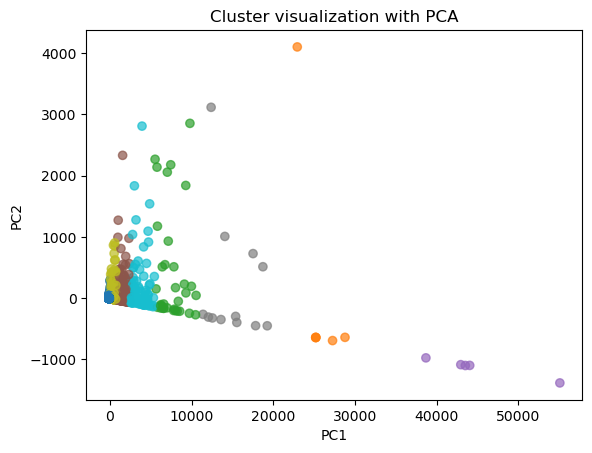

In [5]:
#using PCA to reduce dimensionality
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_encoded)
plt.scatter(data_2d[:,0], data_2d[:,1], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cluster visualization with PCA")
plt.show()

Data Visualization #2

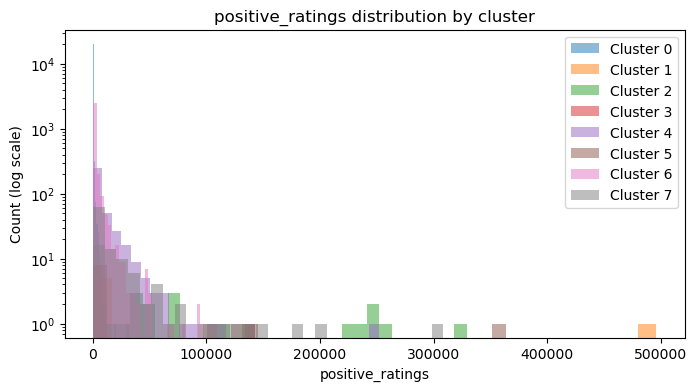

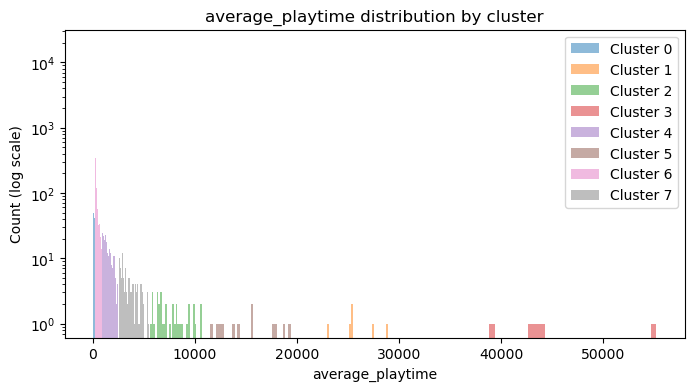

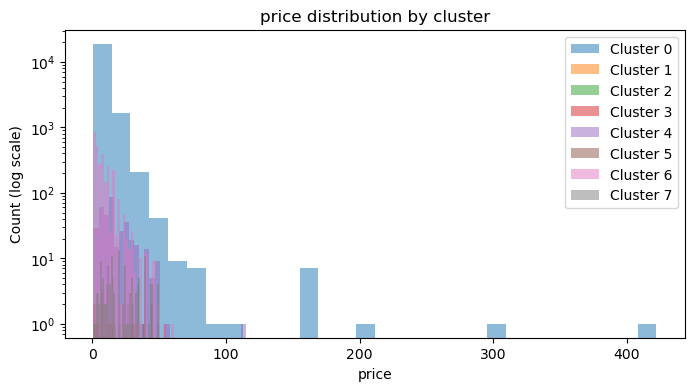

In [6]:
#histograms to show the numerical distribution of the clusters
for feature in num_features:
    plt.figure(figsize=(8,4))
    for cluster_label in sorted(df['cluster'].unique()):
        subset = df[df['cluster'] == cluster_label]
        plt.hist(subset[feature], bins=30, alpha=0.5, label=f'Cluster {cluster_label}', log=True)
    plt.xlabel(feature)
    plt.ylabel('Count (log scale)')
    plt.title(f'{feature} distribution by cluster')
    plt.legend()
    plt.show()

Data Visualization #3

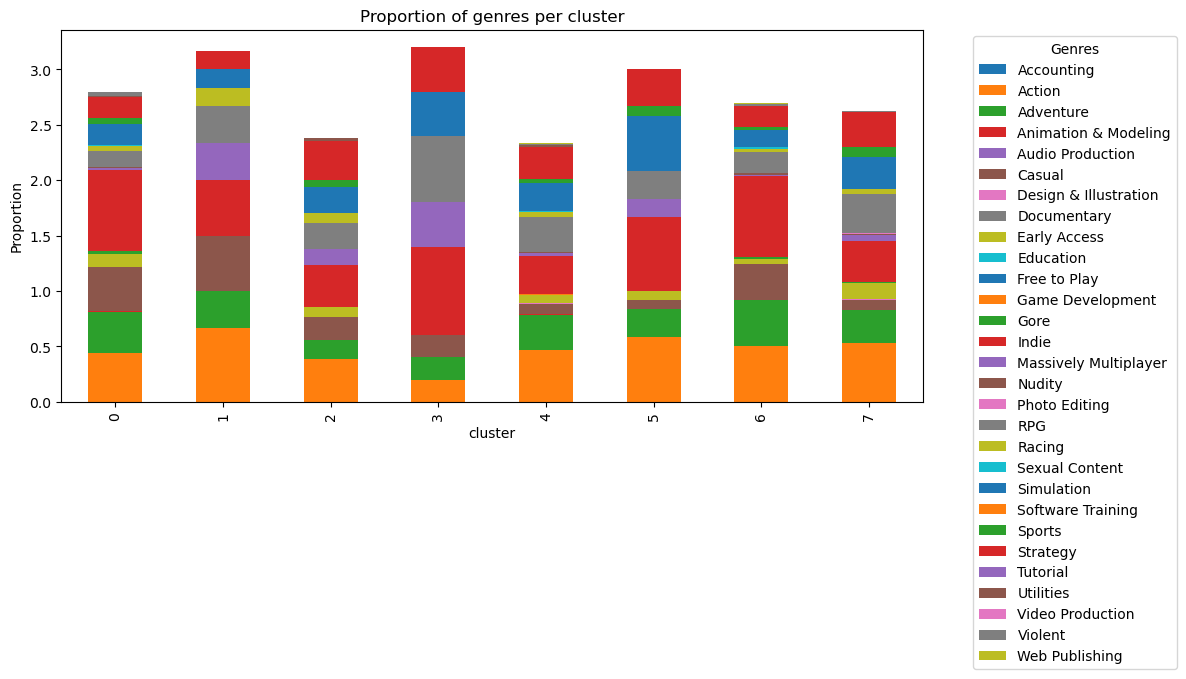

In [7]:
#distribution of genres per cluster
cluster_genres = genre_encoded.copy()
cluster_genres['cluster'] = df['cluster']
cluster_mean = cluster_genres.groupby('cluster').mean()
ax = cluster_mean.plot(kind='bar', stacked=True, figsize=(12,6))

# Move legend to the right side
ax.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Proportion')
plt.title('Proportion of genres per cluster')
plt.tight_layout()  # Adjust layout so nothing is cut off
plt.show()

Creation of functions for widgets

In [8]:
#creation of a search function to use in the widget
def search_game(user_input, df, column="name", limit=10):
    user_input = user_input.lower().strip()
    matches = df[df[column].str.lower().str.contains(user_input, na=False)]
    return matches.head(limit)

search_box = widgets.Text(
    value='',
    placeholder='Type game title',
    description='Search:',
    disabled=False,
    layout = widgets.Layout(width='400px')
)

dropdown =widgets.Dropdown(
    options=[],
    description='Select:',
    disabled=False,
    layout=widgets.Layout(width='400px'),
)

button = widgets.Button(
    description="Recommend",
    layout=widgets.Layout(width='150px'),
    height='40px'
    
)
output = widgets.Output()

#hybrid recommendation function, uses cosine similarity to compare selected game to other games in the cluster
def hybrid_recommend(game_title, n=5):

    # Find cluster
    selected_game = df[df['name'].str.lower() == game_title.lower().strip()]

    if selected_game.empty:
        print(f"Game '{game_title}' not found.")
        return pd.DataFrame()
        
    idx = selected_game.index[0]
    cluster_label = df.loc[idx, "cluster"]

    # Filter to same cluster
    cluster_indices = df[df["cluster"] == cluster_label].index

    # Compute similarity only within cluster
    sim_scores = cosine_similarity(data_encoded.loc[[idx]], data_encoded.loc[cluster_indices]).flatten()
    
    top_indices = cluster_indices[np.argsort(sim_scores)[::-1][1:n+1]]
    recommendations = df.loc[top_indices, ["name", "genres", "positive_ratings", "price"]]
    recommendations["similarity"] = np.sort(sim_scores)[::-1][1:n+1]
    return recommendations
    
# Update dropdown when search box changes
def update_dropdown(change):
    user_input = change['new'].strip()

    if user_input:
        matches = search_game(user_input, df)
        if not matches.empty:
            dropdown.options = [(name, name) for name in matches['name']]
            dropdown.value = None
        else:
            dropdown.options = []
            dropdown.value = None
    else:
        dropdown.options = []
        dropdown.value = None

search_box.observe(update_dropdown, names='value')

# Show recommendations when button clicked
def on_button_click(b):
    with output:
        clear_output()
        if dropdown.value:
            chosen_game = dropdown.value
            recs = hybrid_recommend(chosen_game, n=5)
            if recs.empty:
                print(f"No recommendations found for '{chosen_game}'.")
            else:
                display(recs)
        else:
            print("Please select a game.")
button.on_click(on_button_click)
display(search_box, dropdown, button, output)

Text(value='', description='Search:', layout=Layout(width='400px'), placeholder='Type game title')

Dropdown(description='Select:', layout=Layout(width='400px'), options=(), value=None)

Button(description='Recommend', layout=Layout(width='150px'), style=ButtonStyle())

Output()